# 🔬 Leukocytes images classification using Vision Transformers

***

## 📁 Set up the environment

#### Installing dependencies

In [ ]:
!pip install -q wandb
!pip install -q datasets transformers
!pip install -q plotly-express

#### Importing libraries and logging

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import requests
import seaborn as sns
import torch
from datasets import load_dataset, load_metric
from PIL import Image
from torchvision.transforms import Compose, Normalize, Resize, ToTensor
from tqdm import tqdm
from transformers import (
    AutoFeatureExtractor,
    AutoModelForImageClassification,
    Trainer,
    TrainingArguments,
)

from huggingface_hub import notebook_login
import wandb

In [3]:
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (osxkeychain).
Your token has been saved to /Users/agatapolejowska/.huggingface/token
Login successful


In [4]:
wandb.login()

wandb: Currently logged in as: polejowska. Use `wandb login --relogin` to force relogin


True

In [5]:
run = wandb.init(project="vit-test-lcbsi", entity="polejowska")

## 📚 Loading the dataset



In [8]:
# artifact = run.use_artifact("polejowska/lcbsi-wbc-monai-ai/raw_data:v0", type="dataset")
# artifact_dir = artifact.download()
#  dataset_path = "artifacts/raw_data-v0"
# dataset = load_dataset("imagefolder", data_files={"train": "/content/artifacts/raw_data-v0/train/**", "test": "artifacts/raw_data-v0/test/**", "valid": "artifacts/raw_data-v0/valid/**"})

In [6]:
dataset = load_dataset("polejowska/lcbsi-wbc-ap")

Using custom data configuration polejowska--lcbsi-wbc-ap-35876f5f55923258
Found cached dataset parquet (/Users/agatapolejowska/.cache/huggingface/datasets/polejowska___parquet/polejowska--lcbsi-wbc-ap-35876f5f55923258/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

## 🔍 Explore the dataset

In [7]:
print(f"Dataset structure: {dataset}\n")
print(f"Number of training examples: {len(dataset['train'])}\n")
print(f"Dataset sample (image, label): {dataset['train'][0]}\n")
print(f"Dataset features: {dataset['train'].features}\n")
print(f"Class labels: {dataset['train'].features['label'].names}\n")


Dataset structure: DatasetDict({
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 750
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 750
    })
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3500
    })
})

Number of training examples: 3500

Dataset sample (image, label): {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x2BAACC0A0>, 'label': 0}

Dataset features: {'image': Image(decode=True, id=None), 'label': ClassLabel(names=['basophil', 'eosinophil', 'lymphocyte', 'monocyte', 'neutrophil'], id=None)}

Class labels: ['basophil', 'eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']



In [8]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label


In [9]:
wandb.config.update({"class_labels": dataset["train"].features["label"].names})
wandb.config.update({"num_train_examples": len(dataset["train"])})

#### Visualize data and display essential information

In [13]:
def plot_class_distribution(dataset, id2label, dataset_name="dataset"):
    fig = px.histogram(
        x=[id2label[label] for label in dataset["label"]],
        title=f"Distribution of classes in the {dataset_name}",
    )
    fig.update_layout(xaxis_title="Class", yaxis_title="Number of examples")
    fig.show()
    return fig


enitre_dataset_fig = plot_class_distribution(dataset["train"], id2label)
wandb.log({"class distribution in the entire dataset": enitre_dataset_fig})


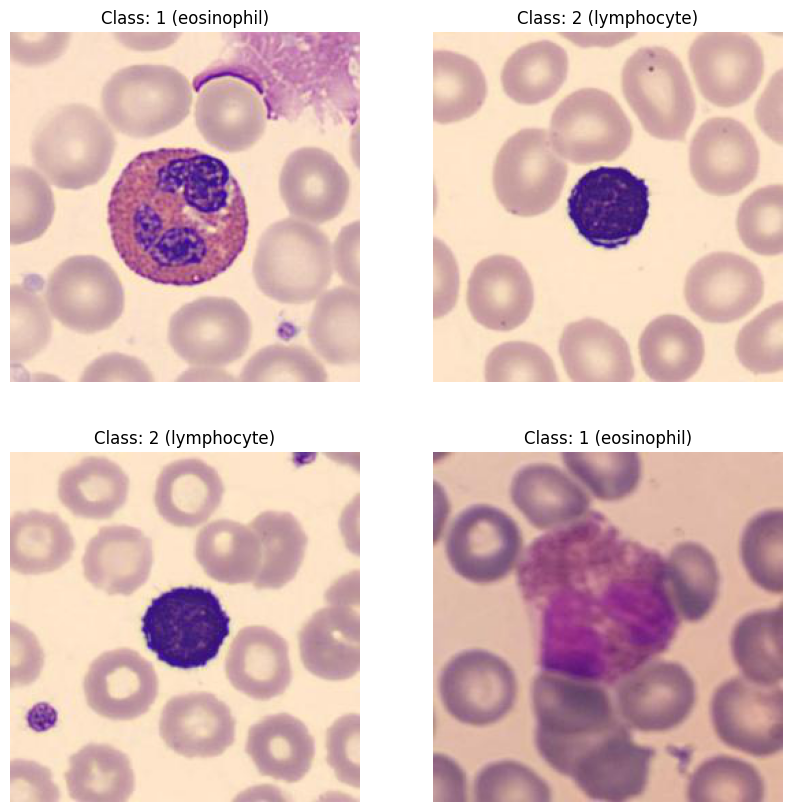

In [14]:
def display_random_images(dataset, label2id, id2label):
    # display four random images from the dataset using plotly
    fig = plt.figure(figsize=(10, 10))
    for i in range(4):
        random_image = np.random.randint(0, len(dataset))
        image = dataset[random_image]["image"]
        label = dataset[random_image]["label"]
        class_name = id2label[label]

        ax = fig.add_subplot(2, 2, i + 1)
        ax.imshow(image)
        ax.set_title(f"Class: {label} ({class_name})")
        ax.axis("off")
    plt.show()

    wandb.log({"random_images": fig})


display_random_images(dataset["train"], label2id, id2label)


***
## 🔨 Data processing

1. Resize images
2. Normalize RGB channels using mean and standard deviation

In [10]:
model_checkpoint = "microsoft/swin-tiny-patch4-window7-224"
# model_checkpoint = "facebook/convnext-tiny-224"
# model_checkpoint = "google/vit-base-patch16-224-in21k"
# model_checkpoint = "nickmuchi/vit-base-xray-pneumonia"

In [11]:
feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)

In [12]:
resize_value = (feature_extractor.size["height"], feature_extractor.size["width"])
# resize_value = (feature_extractor.size['shortest_edge'], feature_extractor.size['shortest_edge'])
print(f"Resize value: {resize_value}")

Resize value: (224, 224)


In [13]:
data_transforms = Compose(
    [
        Resize(resize_value),
        ToTensor(),
        Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
    ]
)

In [14]:
def add_pixel_values_feature(batch):
    batch["pixel_values"] = [
        data_transforms(image.convert("RGB")) for image in batch["image"]
    ]
    return batch

In [15]:
train_dataset = dataset["train"].map(add_pixel_values_feature, batched=True)
validation_dataset = dataset["valid"].map(add_pixel_values_feature, batched=True)
test_dataset = dataset["test"].map(add_pixel_values_feature, batched=True)

print(f"Length of training dataset: {len(train_dataset)}")
print(f"Length of validation dataset: {len(validation_dataset)}")
print(f"Length of test dataset: {len(test_dataset)}")

Loading cached processed dataset at /Users/agatapolejowska/.cache/huggingface/datasets/polejowska___parquet/polejowska--lcbsi-wbc-ap-35876f5f55923258/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-9b4823ffb1ca8b9f.arrow
Loading cached processed dataset at /Users/agatapolejowska/.cache/huggingface/datasets/polejowska___parquet/polejowska--lcbsi-wbc-ap-35876f5f55923258/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-7eb194cbb7935779.arrow
Loading cached processed dataset at /Users/agatapolejowska/.cache/huggingface/datasets/polejowska___parquet/polejowska--lcbsi-wbc-ap-35876f5f55923258/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-0793c616c89591c3.arrow


Length of training dataset: 3500
Length of validation dataset: 750
Length of test dataset: 750


In [24]:
train_dataset_fig = plot_class_distribution(
    train_dataset, id2label, dataset_name="training dataset"
)
wandb.log({"class distribution in the training dataset": train_dataset_fig})

validation_dataset_fig = plot_class_distribution(
    validation_dataset, id2label, dataset_name="validation dataset"
)
wandb.log({"class distribution in the validation dataset": validation_dataset_fig})

test_dataset_fig = plot_class_distribution(
    test_dataset, id2label, dataset_name="test dataset"
)
wandb.log({"class distribution in the test dataset": test_dataset_fig})


In [25]:
wandb.config.update({"num_train_examples": len(train_dataset)})
wandb.config.update({"num_validation_examples": len(validation_dataset)})
wandb.config.update({"num_test_examples": len(test_dataset)})

In [16]:
train_dataset.set_transform(add_pixel_values_feature)
validation_dataset.set_transform(add_pixel_values_feature)
test_dataset.set_transform(add_pixel_values_feature)

#### W&B - log dataset tables

In [27]:
def create_table(dataset):
    table = wandb.Table(columns=["image", "label", "class name"])

    for i in tqdm(range(len(dataset))):
        image, label = dataset[i]["image"], dataset[i]["label"]
        table.add_data(wandb.Image(image), label, id2label[label])

    return table


In [28]:
train_table = create_table(train_dataset)
validation_table = create_table(validation_dataset)
test_table = create_table(test_dataset)

wandb.log({"train_dataset": train_table})
wandb.log({"validation_dataset": validation_table})
wandb.log({"test_dataset": test_table})


100%|██████████| 750/750 [01:09<00:00, 10.84it/s]


***
## 🚋 Model training

In [17]:
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
wandb.watch(model, log="all", log_graph=True)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [19]:
MODEL_NAME = model_checkpoint.split("/")[-1]
NUM_TRAIN_EPOCHS = 10
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
STRATEGY = "epoch"
wandb.run.name = f"{MODEL_NAME} (epochs: {NUM_TRAIN_EPOCHS}) (lr: {LEARNING_RATE})"


args = TrainingArguments(
    f"{MODEL_NAME}-lcbsi",
    remove_unused_columns=False,
    evaluation_strategy=STRATEGY,
    save_strategy=STRATEGY,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="wandb",
    push_to_hub=True,
)

In [20]:
def collate_fn(batches):
    pixel_values = torch.stack([batch["pixel_values"] for batch in batches])
    labels = torch.tensor([batch["label"] for batch in batches])
    return {"pixel_values": pixel_values, "labels": labels}

accuracy_metric = load_metric("accuracy")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
f1_metric = load_metric("f1")

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=eval_pred.label_ids)
    precision = precision_metric.compute(predictions=predictions, references=eval_pred.label_ids)
    recall = recall_metric.compute(predictions=predictions, references=eval_pred.label_ids)
    f1 = f1_metric.compute(predictions=predictions, references=eval_pred.label_ids)
    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"],
    }

/var/folders/44/n5p_mp756952ftqhg9lc__ph0000gn/T/ipykernel_11783/3446354721.py:6: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")


In [21]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=feature_extractor,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)

/opt/miniconda3/envs/lcbsi-ai/lib/python3.9/site-packages/huggingface_hub/repository.py:725: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.12. Please create the repository first using `create_repo(..., exists_ok=True)`.
  warnings.warn(
Cloning https://huggingface.co/polejowska/swin-tiny-patch4-window7-224-lcbsi into local empty directory.


In [22]:
trainer_results = trainer.train()

/opt/miniconda3/envs/lcbsi-ai/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3500
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 270
  Number of trainable parameters = 27523199
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


  0%|          | 0/270 [00:00<?, ?it/s]

{'loss': 1.2973, 'learning_rate': 0.00037037037037037035, 'epoch': 0.36}
{'loss': 0.7103, 'learning_rate': 0.0007407407407407407, 'epoch': 0.73}


***** Running Evaluation *****
  Num examples = 750
  Batch size = 32


  0%|          | 0/24 [00:00<?, ?it/s]

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [ ]:
trainer.save_model()

In [ ]:
trainer.log_metrics("train", trainer_results.metrics)
trainer.save_metrics("train", trainer_results.metrics)

trainer.save_state()

In [ ]:
# save model to W&B
model_artifact = wandb.Artifact(
    f"{MODEL_NAME}-lcbsi-wbc",
    type="model",
    description=f"model trained on {MODEL_NAME} for {NUM_TRAIN_EPOCHS} epochs",
)

wandb.log_artifact(model_artifact)


## 📈 Model evaluation

In [ ]:
metrics = trainer.evaluate()

trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)


In [ ]:
trainer.push_to_hub()


In [ ]:
def create_table_with_predictions(dataset, predictions):
    table = wandb.Table(
        columns=["image", "label", "class name", "prediction", "prediction class name"]
    )

    for i in tqdm(range(len(dataset))):
        image, label = dataset[i]["image"], dataset[i]["label"]
        table.add_data(
            wandb.Image(image),
            label,
            id2label[label],
            predictions[i],
            id2label[predictions[i]],
        )

    return table


In [ ]:
test_predictions = np.argmax(trainer.predict(test_dataset).predictions, axis=1)
test_table_with_predictions = create_table_with_predictions(
    test_dataset, test_predictions
)

wandb.log({"test_table_with_predictions": test_table_with_predictions})


test_table_with_predictions_artifact = wandb.Artifact(
    name="test_table_with_predictions",
    type="test_table_with_predictions",
    description="A table with predictions on the test dataset",
    metadata={
        "num_test_examples": len(test_dataset),
    },
)

test_table_with_predictions_artifact.add(
    test_table_with_predictions, "test_table_with_predictions"
)
wandb.log_artifact(test_table_with_predictions_artifact)

confusion_matrix = wandb.plot.confusion_matrix(
    probs=None,
    y_true=test_dataset[:]["label"],
    preds=test_predictions,
    class_names=list(id2label.values()),
)

wandb.log({"confusion_matrix": confusion_matrix})

In [ ]:
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, class_names):
    fig = go.Figure(data=go.Heatmap(z=cm, x=class_names, y=class_names))
    fig.update_layout(
        title="Confusion Matrix",
        xaxis_title="Predicted label",
        yaxis_title="True label",
        annotations=[
            go.layout.Annotation(
                text=str(round(z, 2)), x=x, y=y, font_size=14, showarrow=False
            )
            for x, y, z in zip(
                np.tile(class_names, len(class_names)),
                np.repeat(class_names, len(class_names)),
                cm.flatten(),
            )
        ],
    )
    fig.show()
    return fig


cm = confusion_matrix(test_dataset[:]["label"], test_predictions)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
cm_plot = plot_confusion_matrix(cm, list(id2label.values()))

wandb.log({"confusion_matrix (plotly)": cm_plot})


In [ ]:
test_accuracy = accuracy_score(test_dataset[:]["label"], test_predictions)
print("Accuracy: {:.2f}%".format(test_accuracy*100))

## Inference using transformers pipeline

In [ ]:
def load_image_from_url(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert("RGB")
    return image


img_url = (
    "https://huggingface.co/spaces/polejowska/LCBSI/resolve/main/95-8-24-1_190_1.jpg"
)
image = load_image_from_url(img_url)


In [ ]:
from transformers import pipeline

repo_name = "polejowska/swin-tiny-patch4-window7-224-lcbsi-wbc"
pipe = pipeline("image-classification", repo_name)


In [ ]:
pipe(image)


In [ ]:
wandb.finish()


W&B report: https://wandb.ai/polejowska/vit-classification-lcbsi/reports/Leukocytes-classification-from-blood-smear-images--VmlldzozMTU1NjI0